In [2]:
import torch
import gym
import logging
import sys
import asciichartpy
import argparse
import _env.cyberbattle_env as cyberbattle_env
from agents.baseline.agent_wrapper import Verbosity
import agents.baseline.agent_dql as dqla
import agents.baseline.agent_wrapper as w
import agents.baseline.plotting as p
import agents.baseline.learner as learner
from __init__ import *
from gym import spaces

In [3]:
parser = argparse.ArgumentParser(description='Run simulation with DQL baseline agent.')

parser.add_argument('--training_episode_count', default=50, type=int,
                    help='number of training epochs')

parser.add_argument('--eval_episode_count', default=10, type=int,
                    help='number of evaluation epochs')

parser.add_argument('--iteration_count', default=9000, type=int,
                    help='number of simulation iterations for each epoch')

parser.add_argument('--reward_goal', default=2180, type=int,
                    help='minimum target rewards to reach for the attacker to reach its goal')

parser.add_argument('--ownership_goal', default=1.0, type=float,
                    help='percentage of network nodes to own for the attacker to reach its goal')

parser.add_argument('--rewardplot_with', default=80, type=int,
                    help='width of the reward plot (values are averaged across iterations to fit in the desired width)')

parser.add_argument('--chain_size', default=20, type=int,
                    help='size of the chain of the CyberBattleChain sample environment')

parser.add_argument('--random_agent', dest='run_random_agent', action='store_false', help='run the random agent as a baseline for comparison')
parser.add_argument('--no-random_agent', dest='run_random_agent', action='store_true', help='do not run the random agent as a baseline for comparison')
parser.set_defaults(run_random_agent=False)

In [4]:
args = parser.parse_known_args()[0]

logging.basicConfig(stream=sys.stdout, level=logging.ERROR, format="%(levelname)s: %(message)s")

print(f"torch cuda available={torch.cuda.is_available()}")

torch cuda available=True


In [5]:
cyberbattlechain = gym.make('CyberBattleChain-v0',
                            size=args.chain_size,
                            attacker_goal=cyberbattle_env.AttackerGoal(
                                own_atleast_percent=args.ownership_goal,
                                reward=args.reward_goal))

ep = w.EnvironmentBounds.of_identifiers(
    maximum_total_credentials=22,
    maximum_node_count=22,
    identifiers=cyberbattlechain.identifiers
)

In [20]:
env = cyberbattlechain.environment

In [24]:
env.network.nodes

NodeView(('start', '21_LinuxNode', '1_LinuxNode', '2_WindowsNode', '3_LinuxNode', '4_WindowsNode', '5_LinuxNode', '6_WindowsNode', '7_LinuxNode', '8_WindowsNode', '9_LinuxNode', '10_WindowsNode', '11_LinuxNode', '12_WindowsNode', '13_LinuxNode', '14_WindowsNode', '15_LinuxNode', '16_WindowsNode', '17_LinuxNode', '18_WindowsNode', '19_LinuxNode', '20_WindowsNode'))

In [26]:
env.get_node('1_LinuxNode')

NodeInfo(services=[ListeningService(name='HTTPS', allowedCredentials=[], running=True), ListeningService(name='SSH', allowedCredentials=['LinuxPassword!1'], running=True)], vulnerabilities={'ProbeLinux': VulnerabilityInfo(description='Probe to check if the node runs Linux', type=<VulnerabilityType.REMOTE: 2>, outcome=<simulation.model.ProbeSucceeded object at 0x7f09803b0250>, precondition=<simulation.model.Precondition object at 0x7f09803a5d60>, rates=Rates(probingDetectionRate=0.0, exploitDetectionRate=0.0, successRate=1.0), URL='', cost=5.0, reward_string='Remote machine is running Linux'), 'ProbeWindows': VulnerabilityInfo(description='Probe to check if the node runs Windows', type=<VulnerabilityType.REMOTE: 2>, outcome=<simulation.model.ProbeFailed object at 0x7f09803b02e0>, precondition=<simulation.model.Precondition object at 0x7f09803a5d60>, rates=Rates(probingDetectionRate=0.0, exploitDetectionRate=0.0, successRate=1.0), URL='', cost=5.0, reward_string='Remote machine is not ru

In [5]:
# cyberbattlechain = gym.make('CyberBattleRandom-v0')

# ep = w.EnvironmentBounds.of_identifiers(
#     maximum_total_credentials=52,
#     maximum_node_count=52,
#     identifiers=cyberbattlechain.identifiers
# )

In [6]:
# cyberbattlechain = gym.make('CyberBattleToyCtf-v0')

# ep = w.EnvironmentBounds.of_identifiers(
#     maximum_total_credentials=52,
#     maximum_node_count=52,
#     identifiers=cyberbattlechain.identifiers
# )

In [8]:
# dir(cyberbattlechain.environment)

In [9]:
for i in range(20):
    print(cyberbattlechain.environment.network.nodes[str(i)]['data'].services)

[ListeningService(name='SMB', allowedCredentials=['unique_pwd10'], running=True)]
[]
[]
[]
[]
[ListeningService(name='RDP', allowedCredentials=['unique_pwd1'], running=True)]
[ListeningService(name='SMB', allowedCredentials=['unique_pwd13'], running=True)]
[]
[]
[ListeningService(name='SMB', allowedCredentials=['unique_pwd2'], running=True)]
[ListeningService(name='RDP', allowedCredentials=['unique_pwd4'], running=True), ListeningService(name='SMB', allowedCredentials=['unique_pwd5'], running=True)]
[ListeningService(name='SMB', allowedCredentials=['unique_pwd6'], running=True)]
[ListeningService(name='SMB', allowedCredentials=['unique_pwd11'], running=True)]
[ListeningService(name='SMB', allowedCredentials=['unique_pwd17'], running=True)]
[]
[]
[ListeningService(name='SMB', allowedCredentials=['unique_pwd8'], running=True)]
[ListeningService(name='SMB', allowedCredentials=['unique_pwd3', 'unique_pwd9'], running=True)]
[]
[ListeningService(name='SMB', allowedCredentials=['unique_pwd14'

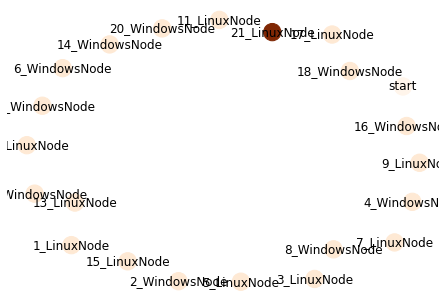

In [6]:
cyberbattlechain.environment.plot_environment_graph()

In [ ]:
# dqn_learning_run = learner.epsilon_greedy_search(
#     cyberbattle_gym_env=cyberbattlechain,
#     environment_properties=ep,
#     learner=dqla.DeepQLearnerPolicy(
#         ep=ep,
#         gamma=0.015,
#         replay_memory_size=10000,
#         target_update=10,
#         batch_size=512,
#         learning_rate=0.01),  # torch default is 1e-2
#     # episode_count=args.training_episode_count,
#     episode_count=1,
#     iteration_count=args.iteration_count,
#     epsilon=0.90,
#     render=False,
#     # epsilon_multdecay=0.75,  # 0.999,
#     epsilon_exponential_decay=5000,  # 10000
#     epsilon_minimum=0.10,
#     verbosity=Verbosity.Quiet,
#     title="DQL"
)

SyntaxError: unmatched ')' (3982261644.py, line 21)